In [1]:
# change into root directory to the project
import os
if os.getcwd().split("/")[-1] == "examples":
    os.chdir('..')

In [2]:
import logging
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)

%load_ext autoreload
%autoreload 2

In [23]:
a = {"asd" : 1, 'xcxc' : 2, "t_BOO" : [1, 2, 3], "tschu" : 666}

In [25]:
for k in a:
    if k.startswith("t"):
        print("starts")
        break
    print(k)

asd
xcxc
starts


In [3]:
import numpy as np
import matplotlib.pyplot as plt

from neurolib.models.aln import ALNModel
from neurolib.utils.parameterSpace import ParameterSpace
from neurolib.optimize.evolution import Evolution
import neurolib.utils.functions as func

from neurolib.utils.loadData import Dataset
ds = Dataset("gw")

# sett dpi for notebooks on server
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['savefig.dpi'] = 600
plt.rcParams['image.cmap'] = 'plasma'

/Users/caglar/anaconda/lib/python3.7/site-packages/deap/tools/_hypervolume/pyhv.py:33: ImportWarning: Falling back to the python version of hypervolume module. Expect this to be very slow.
  "module. Expect this to be very slow.", ImportWarning)


In [40]:
aln = ALNModel(Cmat = ds.Cmat, Dmat = ds.Dmat, simulateBOLD=True) # simulates the whole-brain model in 10s chunks by default if simulateBOLD == True
# Resting state fits
aln.params['mue_ext_mean'] = 1.57
aln.params['mui_ext_mean'] = 1.6
aln.params['sigma_ou'] = 0.09
aln.params['b'] = 5.0

aln.params['dt'] = 0.2
aln.params['duration'] = 1.0 * 60 * 1000 #ms

aln.run()

MainProcess root INFO     Model aln created


In [41]:
def evaluateSimulation(traj):
    rid = traj.id
    #print("Running run id {}".format(rid))

    #model = evolution.loadIndividual(traj)
    model = evolution.getModelFromTraj(traj)  
    model.run()
    
    # -------- fitness evaluation here --------
    
    scores = []
    for i, fc in enumerate(ds.FCs):#range(len(ds.FCs)):
        fc_score = func.matrix_correlation(func.fc(model.BOLD.BOLD[:, 5:]), fc)
        scores.append(fc_score)
    
    fitness = np.mean(scores)
    
    fitness_tuple = ()
    fitness_tuple += (fitness,)
    return fitness_tuple, {}

In [42]:
pars = ParameterSpace(['mue_ext_mean', 'mui_ext_mean'], [[0.0, 2.0], [0.0, 2.0]])

In [43]:
evolution = Evolution(evaluateSimulation, pars, weightList = [-1.0], model = aln, POP_INIT_SIZE=100, POP_SIZE = 20, NGEN=10)

MainProcess root INFO     Storing data to: ./data/hdf/evolution.hdf
MainProcess root INFO     Trajectory Name: results-2020-02-04-11H-26M-52S
MainProcess root INFO     Number of cores: 8
MainProcess pypet.storageservice.HDF5StorageService INFO     I will use the hdf5 file `./data/hdf/evolution.hdf`.
MainProcess pypet.environment.Environment INFO     Environment initialized.
/Users/caglar/anaconda/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMulti' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/Users/caglar/anaconda/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


In [44]:
evolution.run(verbose = True)

MainProcess root INFO     Evaluating initial population of size 100 ...
MainProcess pypet.trajectory.Trajectory INFO     Your trajectory has not been explored, yet. I will call `f_explore` instead.
MainProcess pypet.environment.Environment INFO     I am preparing the Trajectory for the experiment and initialise the store.
MainProcess pypet.environment.Environment INFO     Initialising the storage for the trajectory.
MainProcess pypet.storageservice.HDF5StorageService INFO     Initialising storage or updating meta data of Trajectory `results-2020-02-04-11H-26M-52S`.
MainProcess pypet.storageservice.HDF5StorageService INFO     Finished init or meta data update for `results-2020-02-04-11H-26M-52S`.
MainProcess pypet.environment.Environment INFO     
************************************************************
STARTING runs of trajectory
`results-2020-02-04-11H-26M-52S`.
************************************************************

MainProcess pypet.storageservice.HDF5StorageService INFO  

KeyboardInterrupt: 

Process Process-293:
Process Process-294:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/caglar/anaconda/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/Users/caglar/anaconda/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/Users/caglar/anaconda/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/caglar/anaconda/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/caglar/anaconda/lib/python3.7/site-packages/pypet/environment.py", line 132, in _process_single_run
    result = _sigint_handling_single_run(kwargs)
  File "/Users/caglar/anaconda/lib/python3.7/site-packages/pypet/environment.py", line 259, in _sigint_handling_single_run
    return _single_run(kwargs)
  File "/Users/caglar/anaconda/lib/python3.7/site-packages/pypet/environ

# Analysis

Parameters dictribution (Generation 9):
mue_ext_mean: 	 mean: 1.151,	 std: 0.2333
mui_ext_mean: 	 mean: 0.6289,	 std: 0.1932
There are 20 valid individuals
Mean score across population: -0.65


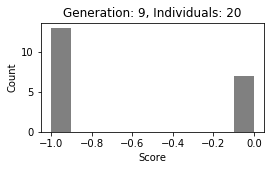

<Figure size 432x288 with 0 Axes>

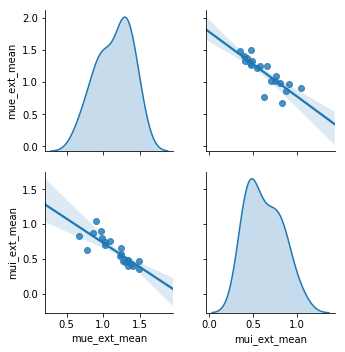

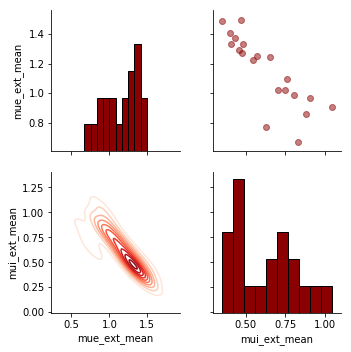

--------------------------
Best 20 individuals:
Printing 20 individuals
Individual 0 pars mue_ext_mean 1.245, mui_ext_mean 0.6535
	Fitness values:  0.0
Individual 1 pars mue_ext_mean 1.024, mui_ext_mean 0.7068
	Fitness values:  0.0
Individual 2 pars mue_ext_mean 1.271, mui_ext_mean 0.4753
	Fitness values:  0.0
Individual 3 pars mue_ext_mean 0.9871, mui_ext_mean 0.8054
	Fitness values:  0.0
Individual 4 pars mue_ext_mean 1.333, mui_ext_mean 0.4825
	Fitness values:  0.0
Individual 5 pars mue_ext_mean 1.248, mui_ext_mean 0.5755
	Fitness values:  0.0
Individual 6 pars mue_ext_mean 1.293, mui_ext_mean 0.4619
	Fitness values:  0.0
Individual 7 pars mue_ext_mean 0.6714, mui_ext_mean 0.8313
	Fitness values:  1.0
Individual 8 pars mue_ext_mean 1.332, mui_ext_mean 0.4083
	Fitness values:  1.0
Individual 9 pars mue_ext_mean 0.906, mui_ext_mean 1.043
	Fitness values:  1.0
Individual 10 pars mue_ext_mean 1.495, mui_ext_mean 0.471
	Fitness values:  1.0
Individual 11 pars mue_ext_mean 1.099, mui_ext_

In [10]:
evolution.info()

In [11]:
# This will load results from disk in case the session is 
# started newly and the trajectory is not in memory
traj = evolution.loadResults()

MainProcess root INFO     Loading results from ./data/hdf/evolution.hdf
MainProcess root INFO     Analyzing trajectory results-2020-02-04-00H-24M-33S
MainProcess pypet.storageservice.HDF5StorageService INFO     I will use the hdf5 file `./data/hdf/evolution.hdf`.
MainProcess pypet.storageservice.HDF5StorageService INFO     Loading trajectory `results-2020-02-04-00H-24M-33S`.
MainProcess pypet.storageservice.HDF5StorageService INFO     Loading branch `config` in mode `2`.
MainProcess pypet.storageservice.HDF5StorageService INFO     Loading branch `derived_parameters` in mode `1`.
MainProcess pypet.storageservice.HDF5StorageService INFO     Loading branch `parameters` in mode `2`.
MainProcess pypet.storageservice.HDF5StorageService INFO     Loading branch `results` in mode `1`.


In [15]:
gens, all_scores = evolution.getScoresDuringEvolution(reverse=True)

In [16]:
gens

array([1, 2, 3, 4, 5, 6, 7, 8, 9])

Text(0, 0.5, 'Score')

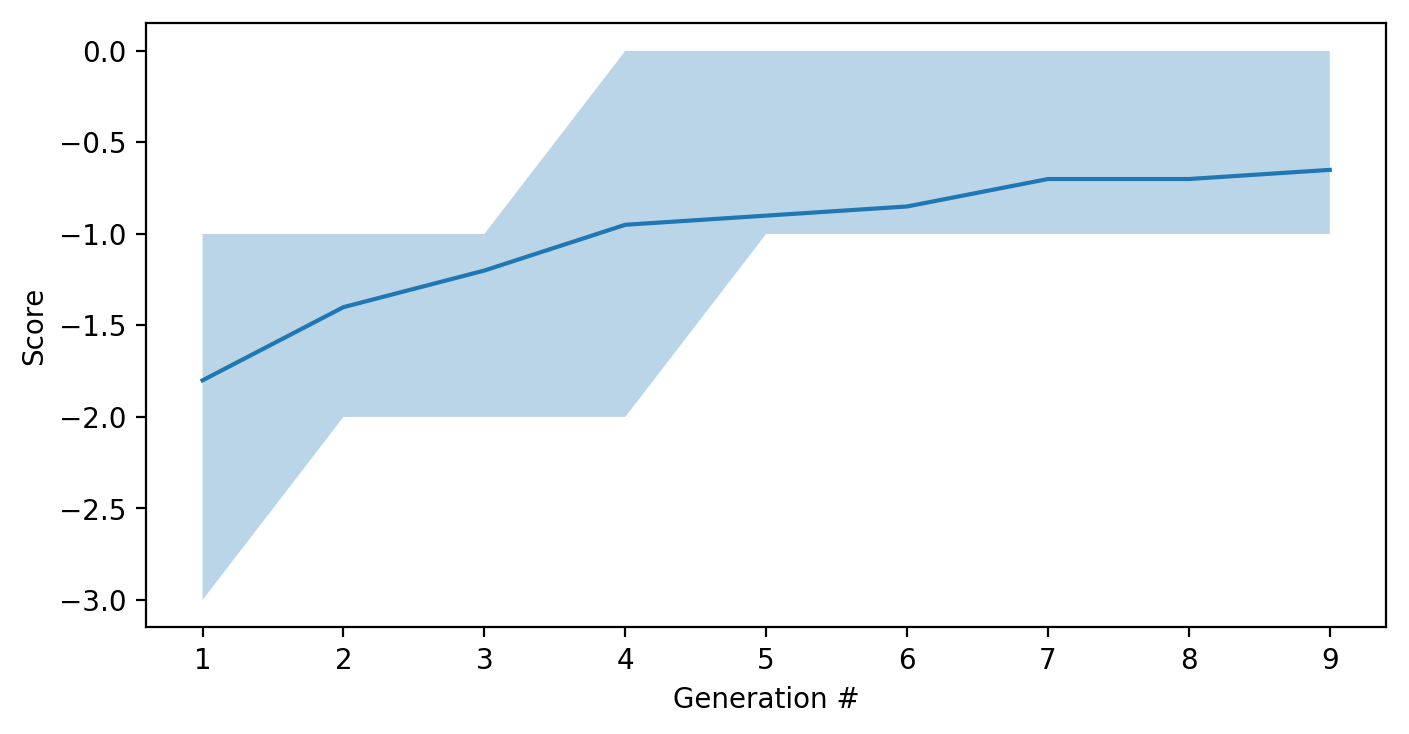

In [17]:
plt.figure(figsize=(8, 4), dpi=200)   
plt.plot(gens, np.nanmean(all_scores, axis=1))
plt.fill_between(gens, np.nanmin(all_scores, axis=1), np.nanmax(all_scores, axis=1), alpha=0.3)
plt.xlabel("Generation #")
plt.ylabel("Score")

In [153]:
import neurolib.utils.paths as paths

In [154]:
HDF_FILE = os.path.join(paths.HDF_DIR, 'evolution.hdf')
trajectoryFileName = HDF_FILE

In [155]:
trajectoryFileName

'./data/hdf/evolution.hdf'

In [156]:
# ---- load pypet trajectory "trajectoryFileName" ----
print("Analyzing File \"{}\"".format(trajectoryFileName))
print("All Trajectories:")
print(pe.getTrajectoryNameInsideFile(trajectoryFileName))
trajectoryName = pe.getTrajectoryNameInsideFile(trajectoryFileName)[-1]

print("Analyzing trajectory \"{}\".".format(trajectoryName))
trajLoaded = pp.Trajectory(trajectoryName,add_time=False)
trajLoaded.f_load(trajectoryName,filename=trajectoryFileName, force=True)
trajLoaded.v_auto_load = True
print("{} results found".format(len(trajLoaded.f_get_results())))

Analyzing File "./data/hdf/evolution.hdf"
All Trajectories:


NameError: name 'pe' is not defined

In [61]:
evolution.toolbox.individual()

[2.2841342671841405,
 1.881658432891666,
 0.2219763831739735,
 1.3333333333333333,
 1.3333333333333333,
 0.09666666666666666]

In [49]:
# This should be done in order to save the objectives for later reconstruction!!! it's not necessary during the simulation since we can always load the dataset
# in the notebook with ds = Dataset() and use it in the evaluation function. 

# save fitting data into trajectory for fitness evaluation later
def init_trajectory(traj):
    traj.f_add_parameter_group("fitness_objectives")
    traj.f_add_parameter_group("fitness_objectives.FC")
    traj.f_add_parameter('fitness_objectives.n_FC', NSUBJECTS, comment='Number of FC matrices')
    for i in range(NSUBJECTS):
        traj.f_add_parameter('fitness_objectives.FC.FC_{}'.format(i), FCs[i], comment='FC matrix of Subject {}'.format(i))
    #traj.f_store()    
init_trajectory(traj)

7.184749007504989

In [ ]:
def simulate_individual(traj):
    # either pass an individual or a pypet trajectory with the attribute individual
    if type(traj).__name__ == 'Individual':
        individual = traj
    else:
        individual = traj.individual
    
    rid = traj.id
    print("Running ID {}".format(rid))
    
    result_dict = {"t_BOLD" : None, "BOLD" : None, "t_rates" : None, "rates_exc" : None}
    invalid_result = result_dict.copy()
    
    # Check if the params are valid
    if not du.check_param_validity(individual, paramInterval):
        if (debug_output):
            print('WARN: invalid paramteres')
        # abort run
        return invalid_result    
        
    # Return fast dummy output for testing purposes
    if dummy_output:
        if random.random() < 0.1:
            return invalid_result
        else:
            t_rates = np.array(range(200))
            rates_exc = np.random.random((80, 200))
            t_BOLD = np.array(range(20))
            BOLD = np.random.random((80, 20))
            result_dict = {"t_BOLD" : t_BOLD, "BOLD" : BOLD, "t_rates" : t_rates, "rates_exc" : rates_exc}
            return result_dict
    
    # Load this individual's parameters
    params = copy.deepcopy(defaultParams) # copy default parameters 
    indiv_dict = du.indivAsDict_adapt(individual, ParametersInterval, paramInterval)
    params.update(indiv_dict) # and then update this individual's specific parameters

    # STAGE 1
    # -------------------------
    # First run the network, to ensure there is some activity
    params['dt'] = 0.1
    params['duration'] = 10*1000.
    
    retVals = ti.timeIntegration(params)
    rates_exc, rates_inh, t, mufe, mufi, IA, seem, seim, siem, siim, \
                seev, seiv, siev, siiv, r_ext_chunk, mue_ext_chunk = retVals

    #print 'pars:', 'Ke_gl', params['Ke_gl'], 'mue_ext_mean', params['mue_ext_mean'], 'sigmaou', params['sigma_ou']        
    if np.max(rates_exc[:,5000:]) > 0.3 or np.max(rates_exc[:,5000:]) < 0.01:
        if (debug_output):
            pass
            #print(rid, 'rate stuck: np.max(rates_exc[:,5000:]) = {}'.format(np.max(rates_exc[:,5000:])))
            #plt.plot(rates_exc.T)
            #plt.show()
        return invalid_result
    
    # STAGE 2
    # -------------------------    
    # BOLD for 20 seconds to see if it overflows
    params['dt'] = 0.2
    params['duration'] = 20*1000.
    t_BOLD, BOLD, return_tuple = cw.chunkwiseTimeIntAndBOLD(params)
    rates_exc, rates_inh, \
                            mufe, mufi, IA, seem, seim, siem, siim, \
                            seev, seiv, siev, siiv, integrated_chunk, rhs_chunk = return_tuple
    if np.std(BOLD[:, 5:7]) < 0.001:
        if (debug_output):
            pass
            #print(rid, 'BOLD stuck: np.std(BOLD[:, 5:7]) = {}'.format(np.std(BOLD[:, 5:7])))
            #plt.plot(BOLD.T)
            #plt.show()
        return invalid_result    
    if (debug_output):
        pass
        #print(rid, 'continue simulation')
                  

    # STAGE 3
    # -------------------------    
    params['dt'] = 0.2
    params['duration'] = defaultParams['duration']

    
    t_BOLD, BOLD, return_tuple = cw.chunkwiseTimeIntAndBOLD(params, chunkSize=10000)
    rates_exc, rates_inh, \
                            mufe, mufi, IA, seem, seim, siem, siim, \
                            seev, seiv, siev, siiv, integrated_chunk, rhs_chunk = return_tuple
    
    t_rates = np.linspace(0, len(rates_exc[0])*params['dt'], len(rates_exc[0]))
    
    if np.max(rates_exc[:,5000:]) > 0.3 or np.max(rates_exc[:,5000:]) < 0.01:
        if (debug_output):
            print(rid, 'continued but rate overflow/stuck')
            #print(rid, '-------------------------')
            #print(rid, 'pars', ', '.join([ ' '.join([k, str(params[k])]) for k in paramInterval._fields]))
            #print(rid, 'np.max(rates_exc[:,5000:])', np.max(rates_exc[:,5000:]))
            #print(rid, 'np.std(BOLD[:, 5:7])', np.std(BOLD[:, 5:7]))
            #f, (ax2, ax3) = plt.subplots(2, 1)
            #ax2.set_title(rid)
            #ax2.plot(BOLD.T)
            #ax3.plot(rates_exc.T)
            #plt.show()
            #print('------------------------------'            )
        return invalid_result 
    if np.std(BOLD[:, 5:7]) < 0.004:
        if (debug_output):
            print(rid, 'continued but BOLD stuck')
        return invalid_result
    if len([i for i in range(N) if np.max(BOLD[i, 15:20]) > 0.001]) < N-2:
        if (debug_output):
            print(rid, 'continued but BOLD overflow ')
            #plt.plot(BOLD.T)
            #plt.title(rid)
            #plt.show()
        return invalid_result      
    
    # if all went ok...
    downsample_to = params['save_dt']
    if downsample_to != None:
        t = t[::int(downsample_to / params['dt'])]
        rates_exc = rates_exc[:, ::int(downsample_to / params['dt'])]
        rates_inh = rates_inh[:, ::int(downsample_to / params['dt'])]
        #stimulus = stimulus[:, ::int(downsample_to / params['dt'])] # does not work if stimulus is just a float!
        
    result_dict = {"t_BOLD" : t_BOLD, "BOLD" : BOLD, "t_rates" : t_rates, "rates_exc" : rates_exc}
    
    return result_dict    # DEAP wants a tuple here!

def evaluate_individual(traj):
    # either pass an individual or a pypet trajectory with the attribute individual
    if type(traj).__name__ == 'Individual':
        individual = traj
    else:
        individual = traj.individual
        
    simulation_results = simulate_individual(traj)
    #print(simulation_results)
    
    NSUBJECTS = traj.fitness_objectives.n_FC
    rid = traj.id
    
    fitness_tuple = ()
    
    BOLD = simulation_results['BOLD']
    t_BOLD = simulation_results['t_BOLD']
    rates_exc = simulation_results['rates_exc']
    
    if BOLD is not None:
        FC_OFFSET = 10 * 1000 # Offset in milliseconds in the simuated BOLD to compute the FC matrix
        FC_sim = func.fc(BOLD[:, t_BOLD > FC_OFFSET])           
        for i in range(NSUBJECTS):
            this_FC = traj.fitness_objectives.FC['FC_{}'.format(i)]
            fitness_tuple += (func.matrix_correlation(FC_sim, this_FC),)
        FCcorr = np.mean(fitness_tuple)
        if (debug_output):
            print(rid, '-------------------------')
            print(rid, 'pars', ', '.join([ ' '.join([k, str(params[k])]) for k in paramInterval._fields]))
            print(rid, 'FC', FCcorr)
            print(rid, 'fitness_tuple')
            print(fitness_tuple)
            print(rid, 'np.max(rates_exc[:,5000:])', np.max(rates_exc[:,100:]))
            print(rid, 'np.std(BOLD[:, 5:7])', np.std(BOLD[:, 5:7]))
            f, (ax1, ax2, ax3) = plt.subplots(3, 1)
            ax1.imshow(FC_sim)
            ax1.set_title(rid)
            ax2.imshow(scipy.stats.mstats.zscore(BOLD[:, t_BOLD > FC_OFFSET], axis=1))
            ax3.plot(rates_exc.T)
            plt.show()
            print('------------------------------')            
    else:
        fitness_tuple = (np.nan, )* NSUBJECTS
    return (fitness_tuple, simulation_results)

In [12]:
def unpackOutputsAndStore(outputs, save_string):
    for key, value in outputs.items():
        new_save_string = save_string
        if isinstance(value, dict):
            new_save_string = save_string + "." + key
            print(save_string)
            unpackOutputsAndStore(value, new_save_string)
        else:
            print("-----------------------")
            print("save_string", new_save_string)
            #print("Adding", key, value)
            print('{}.{}'.format(new_save_string, key), value)
unpackOutputsAndStore(alnModel.outputs, save_string = '{}.ind_{:06d}'.format("outputs", 123))

outputs.ind_000123
-----------------------
save_string outputs.ind_000123.rates
outputs.ind_000123.rates.t [0.0000e+00 1.0000e-01 2.0000e-01 ... 1.9998e+03 1.9999e+03 2.0000e+03]
-----------------------
save_string outputs.ind_000123.rates
outputs.ind_000123.rates.rates_exc [[8.33146236e+01 7.23844726e+01 6.57587880e+01 ... 2.21892867e-02
  2.27298728e-02 2.32727878e-02]]
-----------------------
save_string outputs.ind_000123.rates
outputs.ind_000123.rates.rates_inh [[73.09666604 67.38598775 63.30308389 ...  0.17675581  0.17761642
   0.17849476]]
outputs.ind_000123
-----------------------
save_string outputs.ind_000123.BOLD
outputs.ind_000123.BOLD.t [0.1]
-----------------------
save_string outputs.ind_000123.BOLD
outputs.ind_000123.BOLD.BOLD [[1.38468509e-10]]
